In [59]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns

In [60]:
dist_dim = 2
mix_dim = 3
mix_dist = 5
N = 1000

distance_scale = 1

<Axes: >

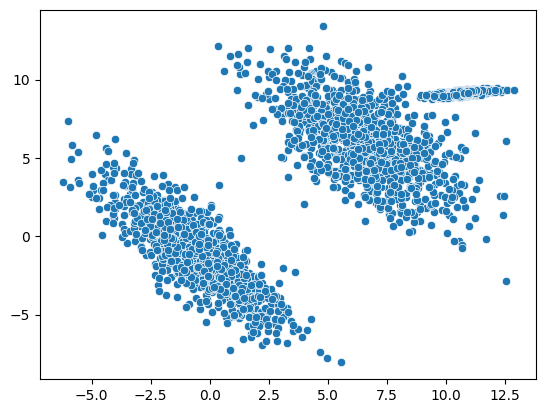

In [61]:
X_lst = []
initial_mean_lst = []
initial_cov_lst = []
for idx in range(mix_dim):
    initial_mean = np.random.uniform(-2, 2, size=[2]) + mix_dist * idx * distance_scale
    # initial_mean = np.random.uniform(-2, 2, size=[2])
    initial_mean_lst.append(initial_mean)
    initial_cov = np.random.uniform(-2, 2, size=[2, 2])
    initial_cov = initial_cov @ initial_cov.T
    initial_cov_lst.append(initial_cov)
    X = np.random.multivariate_normal(mean=initial_mean, cov=initial_cov, size=N)
    X_lst.append(X)

X = np.concatenate(X_lst, axis=0)
initial_mean = np.array(initial_mean_lst)
initial_cov = np.array(initial_cov_lst)
initial_mix = np.array([1 / mix_dim] * mix_dim)

sns.scatterplot(x=X[:, 0], y=X[:, 1])

In [62]:
# mean = np.random.uniform(-2, 2, size=[mix_dim, dist_dim]) + np.stack([np.arange(mix_dim) * mix_dist] * dist_dim, axis=1)
# cov = np.random.uniform(-2, 2, size=[mix_dim, dist_dim, dist_dim])
# cov = cov @ np.transpose(cov, axes=[0, 2, 1])

k_means = KMeans(n_clusters=mix_dim)
k_means.fit(X)

mean = k_means.cluster_centers_
cov = np.stack([np.cov(X[k_means.labels_ == label].T, ddof=1) for label in np.unique(k_means.labels_)], axis=0)
mix = np.random.uniform(0, 1, size=mix_dim)
mix = mix / np.sum(mix)

mean_mse = []
cov_mse = []
mix_mse = []
mean_mse.append(np.mean((mean - initial_mean) ** 2))
cov_mse.append(np.mean((cov - initial_cov) ** 2))
mix_mse.append(np.mean((mix - initial_mix) ** 2))

for iter in range(1000):
    # Expectation Step
    prob = np.array(
        [
            multivariate_normal(
                mean=component_mean, cov=component_cov, allow_singular=True
            ).pdf(X)
            * component_mix
            for component_mean, component_cov, component_mix in zip(mean, cov, mix)
        ]
    )
    # Maximization Step
    prob = prob / np.sum(prob, axis=0)
    mix = np.mean(prob, axis=1)
    mean = (
        np.sum(prob[:, :, None] * X, axis=1) / np.sum(prob, axis=1)[:, None]
    )
    cov = (
        np.sum(
            prob[:, :, None, None]
            * np.transpose(
                X[:, None, :] - mean[None, :, :], axes=[1, 0, 2]
            )[:, :, :, None]
            @ np.transpose(
                X[:, None, :] - mean[None, :, :], axes=[1, 0, 2]
            )[:, :, None, :],
            axis=1,
        )
        / np.sum(prob, axis=1)[:, None, None]
    )

    mean_mse.append(np.mean((mean - initial_mean) ** 2))
    cov_mse.append(np.mean((cov - initial_cov) ** 2))
    mix_mse.append(np.mean((mix - initial_mix) ** 2))

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


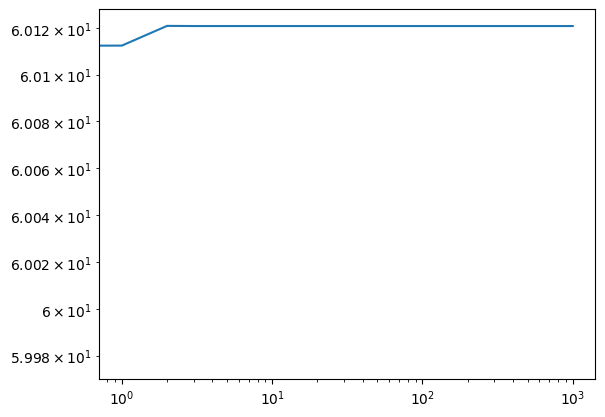

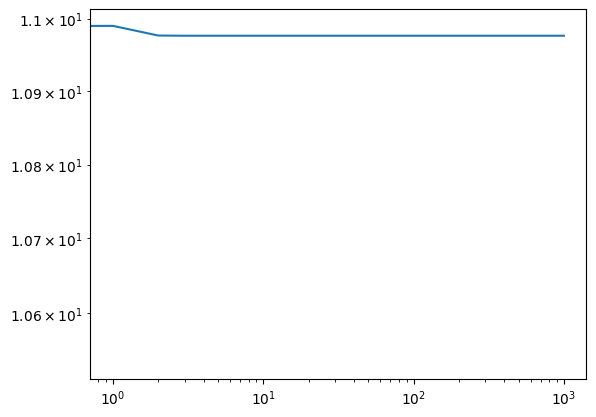

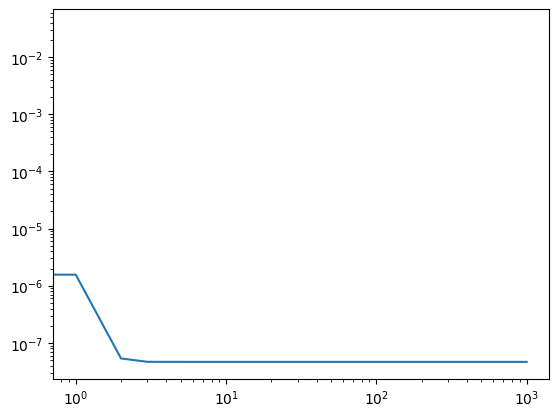

In [63]:
plt.figure()
plt.loglog(mean_mse)
plt.figure()
plt.loglog(cov_mse)
plt.figure()
plt.loglog(mix_mse)

In [64]:
pred_prob = np.array(
    [
        multivariate_normal(
            mean=component_mean, cov=component_cov, allow_singular=True
        ).pdf(X)
        * component_mix
        for component_mean, component_cov, component_mix in zip(mean, cov, mix)
    ]
)
pred = np.argmax(pred_prob, axis=0)

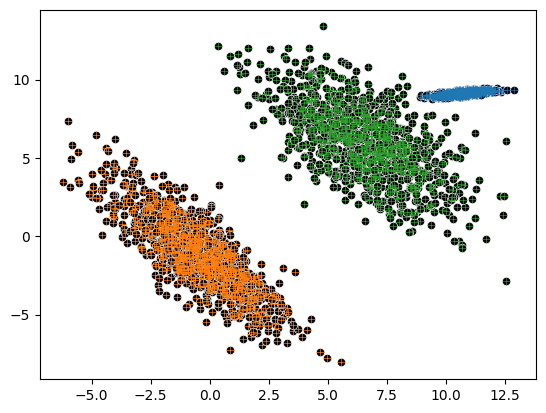

In [65]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], color="k")

for cluster in np.unique(pred):
    sns.scatterplot(x=X[pred == cluster, 0], y=X[pred == cluster, 1], marker="+")

In [66]:
hits = 0
for mix in range(0, mix_dim):
    hits = hits + np.sum(pred[mix * N: (mix+1) * N] == mix)

print(f"Precision: {hits / N / mix_dim * 100}% ")

Precision: 0.0% 
